# Processing training data from raw files

# Notebook n°1

In [1]:
basepath = '/data/conda/recnn/data'

In [2]:
### Importing usefull packages ###
%load_ext cython
import sys
import copy
import numpy as np
import multiprocessing as mp
from functools import partial
from rootpy.vector import LorentzVector
sys.path.append("..")

### Importing preprocessing functions ###
from recnn.preprocessing import _pt
from recnn.preprocessing import randomize
from recnn.preprocessing import multithreadmap
from recnn.preprocessing import sequentialize_by_pt


Welcome to JupyROOT 6.10/08


In [3]:
%%cython -f -+ -I/usr/local/include --link-args=-Wl,-rpath,/usr/local/lib -lm -L/usr/local/lib -lfastjettools -lfastjet -lfastjetplugins -lsiscone_spherical -lsiscone
import numpy as np
cimport numpy as np
np.import_array()

from libcpp.pair cimport pair
from libcpp.vector cimport vector

cdef extern from "/home/yohann/Desktop/stage/recnn/notebooks/fj.cc":
    void fj(vector[double]& a, 
            vector[vector[int]]& trees, 
            vector[vector[double]]& contents, 
            vector[double]& masses, 
            vector[double]& pts, 
            double R, int jet_algorithm)
    
cpdef cluster(np.ndarray[np.double_t, ndim=2, mode="c"] a, 
              R=1.0, jet_algorithm=0):
    cdef vector[double] v
    cdef vector[vector[int]] trees
    cdef vector[vector[double]] contents
    cdef vector[double] masses
    cdef vector[double] pts 
    for value in a.ravel():
        v.push_back(value)
    
    fj(v, trees, contents, masses, pts, R=R, jet_algorithm=jet_algorithm)
    jets = []
    
    for tree, content, mass, pt in zip(trees, contents, masses, pts):
        tree = np.array(tree).reshape(-1, 2)
        content = np.array(content).reshape(-1, 4)
        jets.append((tree, content, mass, pt))
        
    return jets

cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /opt/deeplearning/anaconda/lib/python2.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:0,
                 from /opt/deeplearning/anaconda/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /opt/deeplearning/anaconda/lib/python2.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/yohann/.cache/ipython/cython/_cython_magic_150e52ae2b2b8b313dcff0ae88f1ce74.cpp:535:
/opt/deeplearning/anaconda/lib/python2.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^


In [4]:
def cast(event, soft=0):
    """
    Converts an envent into a list of p4, usable by fastjet
    """
    a = np.zeros((len(event)+soft, 4))
    for i, p in enumerate(event):
        a[i, 3] = p[0]
        a[i, 0] = p[1]
        a[i, 1] = p[2]
        a[i, 2] = p[3]
    
    ### Robustness check : sprinkling soft particles ###
    for i in range(len(event), len(event)+soft):
        v = LorentzVector()
        v.set_pt_eta_phi_m(10e-5, np.random.rand() * 10 - 5, np.random.rand() * 2 * np.pi, 0.0)
        a[i, 0] = v.px
        a[i, 1] = v.py
        a[i, 2] = v.pz
        a[i, 3] = v.e
    
    return(a)


In [5]:
def ff(e):
    """
    create the Jet dictionary stucture from fastjet
    """
    t=cast(e, soft=0)
    tree, content, mass, pt = cluster(t, jet_algorithm=1)[0]  # dump highest pt jet only
    jet = {}
    
    jet["root_id"] = 0
    jet["tree"]    = tree    # tree structure, tree[i] constains [left son, right son] of subjet i
    jet["content"] = content # list of every p4 of every subjet used to create the full jet
    jet["mass"]    = mass
    jet["pt"]      = pt
    jet["energy"]  = content[0, 3]

    px = content[0, 0]
    py = content[0, 1]
    pz = content[0, 2]
    p = (content[0, 0:3] ** 2).sum() ** 0.5
    eta = 0.5 * (np.log(p + pz) - np.log(p - pz))
    phi = np.arctan2(py, px)
    
    jet["eta"]     = eta
    jet["phi"]     = phi
    
    return(jet)

In [6]:
### Loading and "jetting" data with ff ###

signallist = ['/Signal.npy']#'HiggsSUSYGG120',
                                  #'HiggsSUSYBB2600',
                                  #'DY1JetsToLL_M50_LO',
                                  #'HiggsSUSYBB3200',
                                  #'HiggsSUSYGG140',
                                  #'HiggsSUSYBB2300',
                                  #'HiggsSUSYGG800',
                                  #'HiggsSUSYGG160']
backgroundlist = ['/Background.npy']#'QCD_Pt15to30',
                                      #'QCD_Pt30to50',
                                      #'QCD_Pt170to300',
                                      #'QCD_Pt80to120',
                                      #'QCD_Pt80to120_ext2',
                                      #'QCD_Pt120to170',
                                      #'QCD_Pt50to80',
                                      #'QCD_Pt170to300_ext',
                                      #'QCD_Pt120to170_ext']

#def app(txt):
#    return('/'+txt+'_dataformat.npy')

#signallist = multithreadmap(app,signallist)
#backgroundlist = multithreadmap(app,backgroundlist)



background = []

for path_file in backgroundlist:
    events = np.array(np.load(basepath+path_file))
    background = background + multithreadmap(ff, events)


signal = []

for path_file in signallist:
    events = np.array(np.load(basepath+path_file))
    signal = signal + multithreadmap(ff, events)

#--------------------------------------------------------------------------
#                         FastJet release 3.0.6
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the terms of the GNU GPLv2.
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#--------------------------------------------------------------------------
#

# Notebook n°2

## W vs QCD

In [7]:
### creating files to be preprocessed ###

nmax = min(len(signal),len(background))
if nmax%2==1:
    nmax -= 1

X = np.array(background[:nmax]+signal[:nmax])
y = np.array([0]*nmax+[1]*nmax)
print(nmax)

110892


# Notebook n°3

### preprocessing function

In [8]:
%%cython -f -+ -I/usr/local/include --link-args=-Wl,-rpath,/usr/local/lib -lm -L/usr/local/lib -lfastjettools -lfastjet -lfastjetplugins -lsiscone_spherical -lsiscone
import numpy as np
cimport numpy as np
np.import_array()

from libcpp.pair cimport pair
from libcpp.vector cimport vector

cdef extern from "/home/yohann/Desktop/stage/recnn/notebooks/fj.cc":
    void fj(vector[double]& a, 
            vector[vector[int]]& trees, 
            vector[vector[double]]& contents, 
            vector[double]& masses, 
            vector[double]& pts, 
            double R, int jet_algorithm)
    
cpdef cluster(np.ndarray[np.double_t, ndim=2, mode="c"] a, 
              R=0.3, jet_algorithm=0):
    cdef vector[double] v
    cdef vector[vector[int]] trees
    cdef vector[vector[double]] contents
    cdef vector[double] masses
    cdef vector[double] pts 
    for value in a.ravel():
        v.push_back(value)
    
    fj(v, trees, contents, masses, pts, R=R, jet_algorithm=jet_algorithm)
    jets = []
    
    for tree, content, mass, pt in zip(trees, contents, masses, pts):
        tree = np.array(tree).reshape(-1, 2)
        content = np.array(content).reshape(-1, 4)
        jets.append((tree, content, mass, pt))
        
    return jets

cc1plus: warning: command line option ‘-Wstrict-prototypes’ is valid for C/ObjC but not for C++
In file included from /opt/deeplearning/anaconda/lib/python2.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1816:0,
                 from /opt/deeplearning/anaconda/lib/python2.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:18,
                 from /opt/deeplearning/anaconda/lib/python2.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from /home/yohann/.cache/ipython/cython/_cython_magic_9b27d35bb8769fc093ccd68b78ff2a4b.cpp:535:
/opt/deeplearning/anaconda/lib/python2.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:15:2: warning: #warning "Using deprecated NumPy API, disable it by " "#defining NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
 #warning "Using deprecated NumPy API, disable it by " \
  ^


In [9]:
def preprocess(jet, output="kt", colinear_splits=0, trimming=0.0):
    """
    preprocesses the data to make it usable by the recnn
    Preprocessing algorithm:
    1. j = the highest pt anti-kt jet (R=1)
    2. run kt (R=0.3) on the constituents c of j, resulting in subjets sj1, sj2, ..., sjN
    3. phi = sj1.phi(); for all c, do c.rotate_z(-phi)
    4. bv = sj1.boost_vector(); bv.set_perp(0); for all c, do c.boost(-bv)
    5. deltaz = sj1.pz - sj2.pz; deltay = sj1.py - sj2.py; alpha = -atan2(deltaz, deltay); for all c, do c.rotate_x(alpha)
    6. if sj3.pz < 0: for all c, do c.set_pz(-c.pz)
    7. finally recluster all transformed constituents c into a single jet
    """
    jet = copy.deepcopy(jet)
    constituents = jet["content"][jet["tree"][:, 0] == -1]
    
    ### Robustness check : Colinear splits ###
    for i in range(colinear_splits):
        j = np.argmax([_pt(c) for c in constituents])
        v = LorentzVector(constituents[j])
        eps = np.random.rand()
        
        p1 = LorentzVector()
        p2 = LorentzVector()
        p1.set_pt_eta_phi_m(v.pt() * eps, v.eta(), v.phi(), v.m() * eps ** 0.5)
        p2.set_pt_eta_phi_m(v.pt() * (1. - eps), v.eta(), v.phi(), 0.0)

        constituents[j][0] = p1.px
        constituents[j][1] = p1.py
        constituents[j][2] = p1.pz
        constituents[j][3] = p1.e
        
        constituents = np.vstack([constituents, 
                                  np.array([[p2.px, p2.py, p2.pz, p2.e]])])

    ### run kt (R=0.3) on the constituents c of j, resulting in subjets sj1, sj2, ..., sjN ###
    subjets = cluster(constituents, R=0.3, jet_algorithm=0)
    
    ### trimming ###
    if trimming > 0.0:
        subjets = [(tree, content, mass, pt) for tree, content, mass, pt in subjets if pt > trimming * jet["pt"]]
    else:
        subjets = [(tree, content, mass, pt) for tree, content, mass, pt in subjets]

    ### Rot phi ###
    # phi = sj1.phi()
    # for all c, do c.rotate_z(-phi)
    v = subjets[0][1][0]
    v = LorentzVector(v)

    phi = v.phi()
    
    for _, content, _, _ in subjets:
        for i in range(len(content)):
            v = LorentzVector(content[i])
            v.rotate_z(-phi)
            content[i, 0] = v[0]
            content[i, 1] = v[1]
            content[i, 2] = v[2]
            content[i, 3] = v[3]

    ### boost ###
    # bv = sj1.boost_vector()
    # bv.set_perp(0)
    # for all c, do c.boost(-bv)
    v = subjets[0][1][0]
    v = LorentzVector(v)
    bv = v.boost_vector()
    bv.set_perp(0)
    for _, content, _, _ in subjets:
        for i in range(len(content)):
            v = LorentzVector(content[i])
            v.boost(-bv)
            content[i, 0] = v[0]
            content[i, 1] = v[1]
            content[i, 2] = v[2]
            content[i, 3] = v[3]
    
    ### Rot alpha ###
    # deltaz = sj1.pz - sj2.pz
    # deltay = sj1.py - sj2.py
    # alpha = -atan2(deltaz, deltay)
    # for all c, do c.rotate_x(alpha)
    if len(subjets) >= 2:
        deltaz = subjets[0][1][0, 2] - subjets[1][1][0, 2]
        deltay = subjets[0][1][0, 1] - subjets[1][1][0, 1]
        alpha = -np.arctan2(deltaz, deltay)
        for _, content, _, _ in subjets:
            for i in range(len(content)):
                v = LorentzVector(content[i])
                v.rotate_x(alpha)
                content[i, 0] = v[0]
                content[i, 1] = v[1]
                content[i, 2] = v[2]
                content[i, 3] = v[3]
    
    ### flip if necessary ###
    # if sj3.pz < 0: for all c, do c.set_pz(-c.pz)
    if len(subjets) >= 3 and subjets[2][1][0, 2] < 0:
        for _, content, _, _ in subjets:
            for i in range(len(content)):
                content[i, 2] *= -1.0
                
    ### finally recluster all transformed constituents c into a single jet ###
    constituents = []
    
    for tree, content, _, _ in subjets:
        constituents.append(content[tree[:, 0] == -1])
        
    constituents = np.vstack(constituents)

    if output == "anti-kt":
        subjets = cluster(constituents, R=100., jet_algorithm=1)
    elif output == "kt":
        subjets = cluster(constituents, R=100., jet_algorithm=0)
    elif output == "cambridge":
        subjets = cluster(constituents, R=100., jet_algorithm=2)
    else:
        raise
    
    jet["tree"]    = subjets[0][0]
    jet["content"] = subjets[0][1]
    v = LorentzVector(jet["content"][0])
    jet["phi"]     = v.phi()
    jet["eta"]     = v.eta()
    jet["energy"]  = v.E()
    jet["mass"]    = v.m()
    jet["pt"]      = v.pt()
    jet["root_id"] = 0
    
    return(jet)

### Convert data

In [10]:
f = basepath+'/npyfiles/26Juin_'
length = len(X)//2


### eliminate single particles ###
i=0
while i < (len(y)):
    if X[i]['tree'].shape == (1, 2):
        X,y=np.delete(X,i),np.delete(y,i)
    else :
        i+=1

In [11]:
### Save all versions of the dataset ###

### anti-kt ###

#random permutation
flush = np.random.permutation(len(X))
X_,y_ = np.copy(X[flush]),np.copy(y[flush])

#preprocess
X_ = multithreadmap(preprocess,X_,output='anti-kt')

#separate training and testing data
X_test, y_test = X_[length:],y_[length:]
X_train, y_train = X_[:length],y_[:length]

#saving
np.save(f+"anti-kt_test.npy",np.array([X_test, y_test]))

np.save(f+"anti-kt_train.npy", np.array([X_train, y_train]))



#--------------------------------------------------------------------------
#                         FastJet release 3.0.6
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the terms of the GNU GPLv2.
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#--------------------------------------------------------------------------
#

In [27]:
### kt ###
flush = np.random.permutation(len(X))
X_,y_ = np.copy(X[flush]),np.copy(y[flush])

X_ = multithreadmap(preprocess,X_,output='kt')


X_test, y_test = X_[length:],y_[length:]
X_train, y_train = X_[:length],y_[:length]


np.save(f+"kt_test.npy",np.array([X_test, y_test]))

np.save(f+"kt_train.npy", np.array([X_train, y_train]))


#--------------------------------------------------------------------------
#                         FastJet release 3.0.6
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the terms of the GNU GPLv2.
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#--------------------------------------------------------------------------
#

In [28]:
### random tree ###
flush = np.random.permutation(len(X))
X_,y_ = np.copy(X[flush]),np.copy(y[flush])


X_=multithreadmap(randomize,multithreadmap(preprocess,X_,output="anti-kt"))

X_test, y_test = X_[length:],y_[length:]
X_train, y_train = X_[:length],y_[:length]


np.save(f+"random_test.npy",np.array([X_test, y_test]))

np.save(f+"random_train.npy", np.array([X_train, y_train]))


#--------------------------------------------------------------------------
#                         FastJet release 3.0.6
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the terms of the GNU GPLv2.
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#--------------------------------------------------------------------------
#

In [29]:
### seq by pt ###
flush = np.random.permutation(len(X))
X_,y_ = np.copy(X[flush]),np.copy(y[flush])

X_=multithreadmap(sequentialize_by_pt,multithreadmap(preprocess,X_,output="anti-kt"),reverse=False)

X_test, y_test = X_[length:],y_[length:]
X_train, y_train = X_[:length],y_[:length]

np.save(f+"seqpt_test.npy",np.array([X_test, y_test]))

np.save(f+"seqpt_train.npy", np.array([X_train, y_train]))


#--------------------------------------------------------------------------
#                         FastJet release 3.0.6
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the terms of the GNU GPLv2.
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#--------------------------------------------------------------------------
#

In [30]:
### seq by pt reversed ###
flush = np.random.permutation(len(X))
X_,y_ = np.copy(X[flush]),np.copy(y[flush])

X_=multithreadmap(sequentialize_by_pt,multithreadmap(preprocess,X_,output="anti-kt"),reverse=True)

X_test, y_test = X_[length:],y_[length:]
X_train, y_train = X_[:length],y_[:length]


np.save(f+"seqpt_reversed_test.npy",np.array([X_test, y_test]))

np.save(f+"seqpt_reversed_train.npy", np.array([X_train, y_train]))


#--------------------------------------------------------------------------
#                         FastJet release 3.0.6
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the terms of the GNU GPLv2.
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code
# and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
#--------------------------------------------------------------------------
#

# Verification of the formating

In [21]:
### Load data to check ###
fd = f+"anti-kt_test.npy"
X, y = np.load(fd)

### import plt and set options ###
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rcParams["figure.figsize"] = (7,6)

In [22]:
### Check for signal ###

a1 = []
w1=[]
for i,j in enumerate(X):
    constituents = j["content"][j["tree"][:, 0] == -1]
#    if len(constituents)>1:
#        constituents = np.delete(constituents,0,0)
    if y[i]==1:
        a1.append(np.array([[LorentzVector(c).eta(), 
                            LorentzVector(c).phi()] for c in constituents]))
        w1.append([LorentzVector(c).pt() for c in constituents])
w1 = [item for sublist in w1 for item in sublist]

w1=100*np.array(w1)/sum(w1)
a1 = np.vstack(a1)

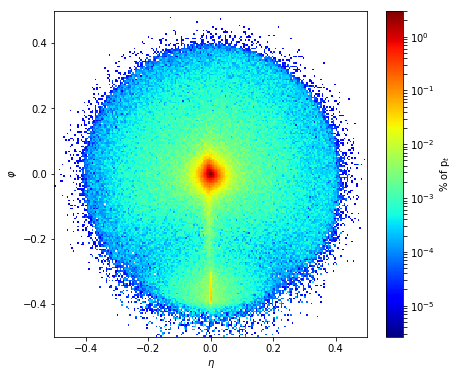

In [23]:
plt.close()
t=plt.hist2d(a1[:, 0], a1[:, 1], range=[(-0.5,0.5), (-0.5,0.5)], 
           bins=200,  cmap=plt.cm.jet,weights=w1,norm=LogNorm())
cbar = plt.colorbar()
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\varphi$')
cbar.set_label(r'% of p$_t$')
#plt.savefig('tau_pfd_log_bis.png',dpi=600, transparent=True)
plt.show()

In [24]:
### For background ###

a = []
w=[]
for i,j in enumerate(X):
    constituents = j["content"][j["tree"][:, 0] == -1]
#    if len(constituents)>1:
#        constituents = np.delete(constituents,0,0)
    if y[i]==0:
        a.append(np.array([[LorentzVector(c).eta(), 
                            LorentzVector(c).phi()] for c in constituents]))
        w.append([LorentzVector(c).pt() for c in constituents])
w = [item for sublist in w for item in sublist]

w=100*np.array(w)/sum(w)
a = np.vstack(a)

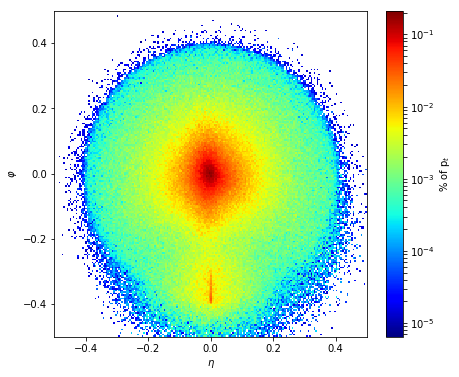

In [25]:
plt.close()
t=plt.hist2d(a[:, 0], a[:, 1], range=[(-0.5,0.5), (-0.5,0.5)], 
           bins=200,  cmap=plt.cm.jet, weights=w,norm=LogNorm())
cbar = plt.colorbar()
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\varphi$')
cbar.set_label(r'% of p$_t$')
#plt.savefig('non_tau_pfd_log_bis.png',dpi=600, transparent=True)
plt.show()

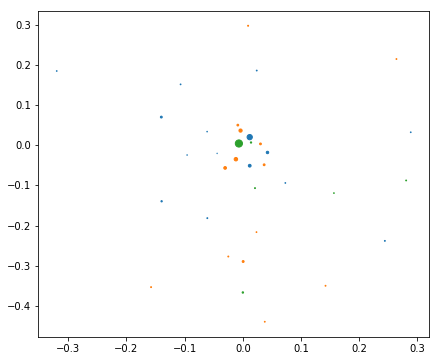

In [26]:
### few taus plotting ###

a = []
w=[]

njets = 10
i0=2000

i1=i0+njets

for i,j in enumerate(X[i0:i1]):
    constituents = j["content"][j["tree"][:, 0] == -1]
    if y[i+i0]==1:
        a.append(np.array([[LorentzVector(c).eta(), 
                            LorentzVector(c).phi()] for c in constituents]))
        w.append([LorentzVector(c).pt() for c in constituents])


for i in range(len(a)):
    plt.scatter(a[i][:,0],a[i][:,1],s=w[i]*100)
plt.show()